THE LATEST VERSION OF THIS NOTEBOOK WILL BE AVAILABLE HERE:
    
https://github.com/hsanda/WorldDataLeagueStageOne


In [ ]:
import pandas as pd
import numpy as np
from ipyleaflet import Map, Marker, basemaps, Polyline, LayersControl, AwesomeIcon, Circle, Rectangle, LayerGroup
import requests
import json
from IPython.display import display
import operator
import ast
import os
import glob
from geopy.distance import lonlat, distance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import pandas as pd
from ipyleaflet import Map, Marker, basemaps, Polyline, LayersControl, AwesomeIcon,Circle,LayerGroup, Rectangle
import requests
import json
import numpy as np
import overpy
api = overpy.Overpass()
import warnings
from pandas.core.common import SettingWithCopyWarning
from geopy.distance import lonlat, distance
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import operator
import ast

# Data Extraction


In this section we show the retrieval of different datasets:

1 The road segment locations based on the linkids provided by WDL
2 Elevation data for each of the roadsegments 
3 The locations of different amenities (pharmacies, arts centres...) in the city of Porto

## Road Segments

We create a dataframe with all the coordinates for each of the unique linkids in the original files. The csv files to load can be found in the Github repo.

It takes approx 5 mins to run, so you may not run this and load the output file ('Coordinates.csv') directly from our repo

In [688]:
#Imports 

bus_routes = pd.read_csv('/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/BusRoutes.csv')
senior_data = pd.read_csv('/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/Senior Transportation - Traffic database.csv')

#Consolidate senior_data on unique linkid
print("Original number of rows: ",len(senior_data['linkid']))
senior_data = senior_data.groupby(['linkid']).sum().reset_index()
print("Number of rows after merging: ", len(senior_data['linkid']))

##create list with unique linkids
linkids = senior_data['linkid'].tolist()


def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def getCoor(linkids):
    counter = 0
    lats = []
    longs = []
    linkid_list = []
    for link_ids in chunks(linkids, 100):
        my_link_ids = ""
        for link in link_ids:  # append the linkids as string with commas
            my_link_ids = my_link_ids + str(link) + ","
        my_link_ids = my_link_ids[:-1]  # remove the comma
       
        href = "https://pde.cit.api.here.com/1/index.json?layer=ROAD_GEOM_FCn&attributes=LINK_ID&values=" + my_link_ids + "&app_id=TEeyCAe1cqCW0b1T8siy&app_code=sjCR7OT26x9kVMPlyXUrgw"
        x = requests.get(href)
        
        layers = ""
        tilexy = ""
        levels = ""

        json_data = json.loads(x.text)
        for child in json_data["Layers"]:
            for p in range(len(child["tileXYs"])):
                layers = layers + str(child["layer"]) + ","
                tilexy = tilexy + str(child["tileXYs"][p]["x"]) + "," + str(child["tileXYs"][p]["y"]) + ","
                levels = levels + str(child["level"]) + ","

        layers = layers[:-1]
        tilexy = tilexy[:-1]
        levels = levels[:-1]

        href2 = "https://pde.api.here.com/1/tiles.json?layers=" + layers + "&levels=" + levels + "&tilexy=" + tilexy + "&app_id=TEeyCAe1cqCW0b1T8siy&app_code=sjCR7OT26x9kVMPlyXUrgw"
        x2 = requests.get(href2)

        json_data = json.loads(x2.text)

        for index in json_data["Tiles"]:
            for row in index["Rows"]:
                if int(row["LINK_ID"]) in link_ids:

                    lat_array = row["LAT"].split(",")
                    lon_array = row["LON"].split(",")

                    lat = []
                    lon = []
                    
                    for item in range(len(lat_array)):
                        if item == 0:
                            lat.append(float(lat_array[item]) / 100000)
                            lon.append(float(lon_array[item]) / 100000)
                        else:
                            try:
                                lat.append(float(lat[item-1]) + (float(lat_array[item]) / 100000))
                            except:
                                lat.append(lat[item-1])
                            try:
                                lon.append(float(lon[item-1]) + (float(lon_array[item]) / 100000))
                            except:
                                lon.append(lon[item-1])
                    
                    
                    linkid_list.append(row['LINK_ID'])
                    lats.append(lat)
                    longs.append(lon)
    df = pd.DataFrame({'linkID':linkid_list,
                             'Latitude':lats,
                             'Longitude': longs})

    #df.to_csv('Coordinates.csv', index=False)

getCoor(linkids)
df.head()

Original number of rows:  121053
Number of rows after merging:  75041


KeyboardInterrupt: 

## Road simplification

From the exploratory data analysis we saw that some roadsegments consist out of many points for a small road section. To reduce the data wihtout losing too much information we decided to make the following simplification: If for one roadsegment the middle points (not the beginning or end point) lie within a X-m range of two other points we remove that point. The decision for the X-boundary of meters was made by looking at the plot showing the amount of data we would keep if we apply the simplification for a certain X value. With the ellbow-method one would use a value of 15m, 20m or 25m but we wanted to be more conservative and went for 15m. 

In [690]:
df = pd.read_csv("/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/Coordinates.csv")

# pre-process data to get location tuples consisting out of (latitude,longtitude)
def split_up_cols(col):
    col=col.apply(lambda x: x.replace("[","")).apply(lambda x: x.replace("]",""))
    col = col.apply(lambda x: x.split(","))
    col=col.apply(lambda x: [float(elem) for elem in x])
    return col

# apply split_up_cols()
df["Latitude"]=split_up_cols(df["Latitude"])
df["Longitude"]=split_up_cols(df["Longitude"])
df["location"]= df.apply(lambda x: list(zip(x.Latitude,x.Longitude)), axis=1)


# function to simplify road segments by eliminating middle points that lie wihtin <=10 min distance of 2 other
# points
def simplify_road_10m(segment,val):
    to_delete=[]
    incr_2=False
    incr_1=False
    for j in range(len(segment[:-2])):
        if incr_1:
            incr_1=False
            continue
        if incr_2:
            incr_2=False
            continue
        temp_d1=distance(segment[j], segment[j+1]).m
        temp_d2=distance(segment[j+1], segment[j+2]).m

        if (temp_d1<15)and(temp_d2<=val):
            to_delete.append(j+1)
            if (j<len(segment[:-2])-2)and(distance(segment[j],segment[j+2]).m<=val):
                to_delete.append(j+2)
                incr_2=True
            incr_1=True
    #perc = str(np.round(old_length/len(segment)*100,2))+"%"
    new_loc = [loc for loc in segment if loc not in [segment[val] for val in to_delete]]
    old_length=len(segment)
    new_length=len(new_loc)
    return new_loc,old_length,new_length


def test_ellbow(df,vals):
    reductions=[]
    for val in vals:
        print("val",val, "from vals:",vals)
        tem_df=df
        tem_df["new_loc"],tem_df["old_length"],tem_df["new_length"]=list(map(list, zip(*tem_df.location.apply(
                lambda x:simplify_road_10m(x,val)))))
        change_perc=np.round((tem_df["old_length"].sum()-tem_df["new_length"].sum())/tem_df[
            "old_length"].sum()*100,2)
        reductions.append(change_perc)
    return vals,reductions

vals=[5+5*x for x in range(15)]  
# comment the following line out if the plot doesn´t need to be looked at as it takes a lot of computations 
result_ellbow = test_ellbow(df,vals) 
plt.scatter(x=result_ellbow[0],y=[100-x for x in result_ellbow[1]])

# apply function with 15m 
df["new_loc"],df["old_length"],df["new_length"]=list(map(list, zip(*df.location.apply(
    lambda x:simplify_road_10m(x,15)))))

# Sumary of effect 
print("nb of original points:",df["old_length"].sum(),"nb of new points:",df["new_length"].sum())
change_perc=np.round((df["old_length"].sum()-df["new_length"].sum())/df["old_length"].sum()*100,2)
print("That is equal to:",change_perc,"% reduction")


# save it
df.to_csv("Coordinates_simplified_road_segments_10m.csv")

val 5 from vals: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
val 10 from vals: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
val 15 from vals: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


KeyboardInterrupt: 

## Elevation of the road segments

csv provided, no need to run the below

In [695]:
import pandas as pd
from ipyleaflet import Map, Marker, basemaps, Polyline, LayersControl, AwesomeIcon,Circle,LayerGroup
import requests
import json
import numpy as np
import overpy
api = overpy.Overpass()
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from geopy.distance import lonlat, distance
import elevation as elevation
import matplotlib.pyplot as plt
import copy
from matplotlib.cm import terrain
from matplotlib.cm import cool
import branca.colormap as cm

In [697]:
# Import bus routes
bus_routes = pd.read_csv('/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/BusRoutes.csv')
df = pd.read_csv("/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/Coordinates_simplified_road_segments_10m.csv")

# pre-process data to get location tuples consisting out of (latitude,longtitude)
def split_up_cols(col):
    col = col.apply(lambda x: x.replace("[","")).apply(lambda x: x.replace("]",""))
    col = col.apply(lambda x: x.split(","))
    col = col.apply(lambda x: [float(elem) for elem in x])
    return col

df["Latitude"] = split_up_cols(df["Latitude"])
df["Longitude"] = split_up_cols(df["Longitude"])
df["location"]= df.apply(lambda x: list(zip(x.Latitude,x.Longitude)), axis=1)

route_map = {}
for index, row in bus_routes.iterrows():
    id_route = int(row["IDRoute"])
    if id_route in route_map:
        route_map[id_route].append(row["linkid"])
    else:
        route_map[id_route] = [row["linkid"]]

        # Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

# https://www.opentopodata.org/v1/srtm30m?locations=
# Since the public site has limited queries and requests per second,
# we host locally with Docker and the downloaded SRTM30 files.
API_ENDPOINT = "http://localhost:5000/v1/srtm30m?locations="
CHUNK_SPLIT = 200
coordinates = []
elevation = []

for index, row in df.iterrows():
    coordinates.extend(row["location"])
            
total_chunks = int(len(coordinates) / CHUNK_SPLIT)
for index, coordinate_chunk in enumerate(list(chunks(coordinates, CHUNK_SPLIT))):
    print("Chunk", index, "of", total_chunks)
    
    # Try three times
    trail = 0
    while (trail < 3):
        query = API_ENDPOINT
        for lat, lon in coordinate_chunk:
            query = query + "{:.5f}".format(lat) + "," + "{:.5f}".format(lon) + "|"
        result = requests.get(query, timeout=60)

        if (result.status_code == 200 or result.status_code == 201):
            for coord_info in json.loads(result.text)["results"]:
                elevation.append(coord_info["elevation"])
            trail = 10
        else:
            print("Error, trail:", trail, "code", result.text)
            trail = trail + 1

print("Done")

# Create a new column with elevation and save the 
df["elevation"] = [[]] * df.shape[0]

iterated_index = 0
for index, row in df_test.iterrows():
    this_length = len(row["location"])
    df["elevation"][index] = elevation[iterated_index:iterated_index + this_length]
    iterated_index = iterated_index + this_length
#df_test.to_csv("data/simplified_road_segments_15m_elevation.csv", sep=',')

df.head()

Chunk 0 of 1559


ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /v1/srtm30m?locations=41.12871,-8.43735%7C41.12875,-8.43754%7C41.12877,-8.43765%7C41.12878,-8.43777%7C38.74734,-9.18980%7C38.74739,-9.18994%7C38.74744,-9.19006%7C38.74752,-9.19024%7C40.98260,-8.19951%7C40.98268,-8.19941%7C40.98279,-8.19929%7C40.98290,-8.19918%7C40.98314,-8.19894%7C40.98320,-8.19888%7C40.98325,-8.19881%7C40.98329,-8.19874%7C40.98332,-8.19866%7C40.98334,-8.19858%7C40.98335,-8.19849%7C40.98337,-8.19826%7C40.98339,-8.19813%7C40.98342,-8.19802%7C40.98346,-8.19793%7C40.98351,-8.19785%7C40.98356,-8.19779%7C40.98370,-8.19767%7C40.98377,-8.19761%7C40.98383,-8.19754%7C40.98388,-8.19745%7C40.98392,-8.19735%7C40.98395,-8.19725%7C40.98398,-8.19713%7C40.98421,-8.19619%7C40.98424,-8.19609%7C40.98428,-8.19600%7C40.98432,-8.19594%7C40.98437,-8.19589%7C40.98443,-8.19586%7C40.98450,-8.19583%7C40.98456,-8.19582%7C40.98463,-8.19581%7C40.98471,-8.19582%7C40.98477,-8.19584%7C40.98483,-8.19587%7C40.98489,-8.19592%7C40.98508,-8.19613%7C40.98515,-8.19619%7C40.98522,-8.19623%7C40.98530,-8.19626%7C40.98538,-8.19627%7C40.98545,-8.19626%7C40.98551,-8.19624%7C40.98558,-8.19620%7C40.98565,-8.19615%7C40.98586,-8.19596%7C40.98595,-8.19590%7C40.98604,-8.19586%7C40.98613,-8.19584%7C40.98623,-8.19582%7C40.98651,-8.19578%7C40.98665,-8.19577%7C40.98675,-8.19578%7C40.98684,-8.19580%7C40.98693,-8.19583%7C40.98702,-8.19587%7C40.98715,-8.19593%7C40.98723,-8.19598%7C40.98730,-8.19603%7C40.98736,-8.19610%7C40.98741,-8.19618%7C40.98744,-8.19626%7C40.98746,-8.19635%7C40.98748,-8.19659%7C40.98749,-8.19669%7C40.98751,-8.19678%7C40.98754,-8.19687%7C40.98759,-8.19697%7C40.98767,-8.19710%7C40.98772,-8.19719%7C40.98777,-8.19729%7C40.98781,-8.19740%7C40.98784,-8.19751%7C40.98786,-8.19763%7C40.98787,-8.19778%7C40.98787,-8.19819%7C40.98786,-8.19864%7C40.99234,-8.21055%7C40.99238,-8.21071%7C40.99241,-8.21086%7C40.99244,-8.21104%7C40.99246,-8.21120%7C40.99254,-8.21181%7C40.99261,-8.21230%7C40.99263,-8.21239%7C40.99265,-8.21245%7C40.99268,-8.21250%7C40.98786,-8.19864%7C40.98786,-8.19889%7C40.98787,-8.19909%7C40.98789,-8.19928%7C40.98792,-8.19947%7C40.98796,-8.19966%7C40.98803,-8.19994%7C40.98808,-8.20010%7C40.98812,-8.20024%7C40.98816,-8.20042%7C40.98819,-8.20058%7C40.98829,-8.20122%7C40.98833,-8.20144%7C40.98837,-8.20161%7C40.98846,-8.20190%7C40.98850,-8.20204%7C40.98853,-8.20219%7C40.98855,-8.20232%7C40.98856,-8.20249%7C40.98857,-8.20276%7C40.98858,-8.20310%7C40.98859,-8.20336%7C40.98861,-8.20360%7C40.98861,-8.20360%7C40.98863,-8.20372%7C40.98866,-8.20381%7C40.98870,-8.20388%7C40.98876,-8.20395%7C40.98882,-8.20400%7C40.98888,-8.20406%7C40.98893,-8.20413%7C40.98897,-8.20422%7C40.98901,-8.20433%7C40.98904,-8.20445%7C40.98907,-8.20457%7C40.98924,-8.20529%7C40.98928,-8.20543%7C40.98933,-8.20555%7C40.98939,-8.20567%7C40.98946,-8.20577%7C40.98955,-8.20591%7C40.98961,-8.20601%7C40.98967,-8.20613%7C40.98973,-8.20626%7C40.99008,-8.20697%7C40.99014,-8.20709%7C40.99019,-8.20718%7C40.99025,-8.20727%7C40.99032,-8.20735%7C40.99047,-8.20752%7C40.99052,-8.20759%7C40.99057,-8.20767%7C40.99061,-8.20775%7C40.99064,-8.20783%7C40.99067,-8.20794%7C40.99071,-8.20809%7C40.99075,-8.20819%7C40.99079,-8.20826%7C40.99085,-8.20833%7C40.99092,-8.20839%7C40.99135,-8.20878%7C40.99145,-8.20888%7C40.99154,-8.20898%7C40.99163,-8.20911%7C40.99170,-8.20922%7C40.99178,-8.20936%7C40.99197,-8.20971%7C40.99205,-8.20986%7C40.99213,-8.21001%7C40.99219,-8.21014%7C40.99225,-8.21028%7C40.99230,-8.21042%7C40.99234,-8.21055%7C40.96299,-8.20507%7C40.96306,-8.20513%7C40.96314,-8.20521%7C40.96321,-8.20529%7C40.96333,-8.20544%7C40.96339,-8.20552%7C40.96344,-8.20561%7C40.94327,-8.57215%7C40.94341,-8.57192%7C40.94411,-8.57071%7C40.94428,-8.57042%7C38.46017,-9.02056%7C38.46025,-9.02191%7C38.46029,-9.02252%7C38.46031,-9.02283%7C38.46033,-9.02309%7C38.46036,-9.02329%7C38.46041,-9.02349%7C38.46047,-9.02369%7C38.46059,-9.02407%7C38.46067,-9.02430%7C38.46077,-9.02451%7C38.46088,-9.02469%7C38.46100,-9.02486%7C38.46113,-9.02500%7C38.46128,-9.02513%7C38.46179,-9.02552%7C38.46282,-9.02631%7C38.46308,-9.02651%7C38.46326,-9.02663%7C38.46338,-9.02670%7C (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8f96c0e100>: Failed to establish a new connection: [Errno 61] Connection refused'))

Since each linkid represents a segment (multiple points), we get multiple elevations for each link id. In order to estimate the elevation of each segment, we compute the average of this values. Additionaly, create a feature to represent the slope of each road segment, by taking the range of elevations for each road segment.

In [ ]:
elevations = df['elevation'].values.tolist()

print('One string element of the list looks like ' + str(elevations[1]))

average_elevation = []
range_elevation = []
for i in range(len(elevations)):
    ele_list = elevations[i].strip('][').split(', ') #need to change elements from str to float
    ele_list = [float(item) for item in ele_list]
    
    avg = sum(ele_list)/len(ele_list) #compute average elevation
    
    rang = max(ele_list) - min(ele_list) #compute the range
    
    average_elevation.append(avg) #append to list
    range_elevation.append(rang) 
    
df['avg_elevation'] = np.array(average_elevation)
df['range_elevation'] = np.array(range_elevation)
df.head()



Showing route with elevation for  Route 160
77309 374 111


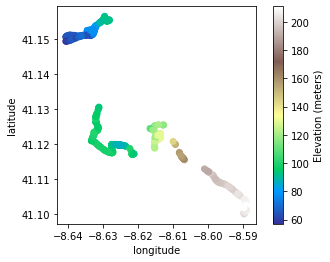

Map(center=[41.14961, -8.61099], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…



Showing route with elevation for  Route 161
77309 114 33


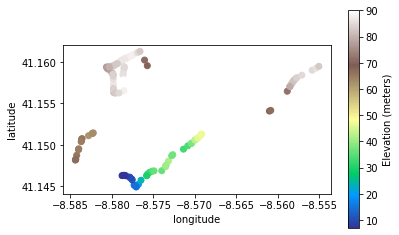

Map(center=[41.14961, -8.61099], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [709]:
df = pd.read_csv("/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/simplified_road_segments_15m_elevation_comma.csv", sep=',')

# pre-process data to get location tuples consisting out of (latitude,longtitude)
def split_up_cols(col):
    col = col.apply(lambda x: x.replace("[","")).apply(lambda x: x.replace("]",""))
    col = col.apply(lambda x: x.split(","))
    col = col.apply(lambda x: [float(elem) for elem in x])
    return col

df["Latitude"] = split_up_cols(df["Latitude"])
df["Longitude"] = split_up_cols(df["Longitude"])
df["location"]= df.apply(lambda x: list(zip(x.Latitude,x.Longitude)), axis=1)
df["elevation"]= split_up_cols(df["elevation"])

route_map = {}
for index, row in bus_routes.iterrows():
    id_route = int(row["IDRoute"])
    if id_route in route_map:
        route_map[id_route].append(row["linkid"])
    else:
        route_map[id_route] = [row["linkid"]]
        

# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]
df_test = df
min_value = min([min(x) for x in df_test["elevation"]])
max_value = max([max(x) for x in df_test["elevation"]])
section = (max_value - min_value) / 4
colormap = cm.LinearColormap(colors=['blue','green', 'yellow', 'brown'], 
                 index=[min_value, min_value + section, min_value + section*2, max_value], 
                 vmin=min_value, vmax=max_value)
colormap

def add_route(name, link_ids_chunk):
    #print(link_ids_chunk)
    print("\n\nShowing route with elevation for ", name)
    center = (41.14961, -8.61099)
    m = Map(center=center, zoom=10)
    
    # Select the linkids for our route id
    #route_pd = df_test[~df_test['linkID'].isin(link_ids_chunk)]
    route_pd = df_test[df_test['linkID'].isin(link_ids_chunk)]
    print(len(df_test['linkID']), len(link_ids_chunk), len(route_pd))
    
    # Plot the route with color scheme
    data = {"lat": [], "lon": [], "elev": []}
    
    for index, segment in route_pd.iterrows():
        data["lat"].extend(segment["Latitude"])
        data["lon"].extend(segment["Longitude"])
        data["elev"].extend(segment["elevation"])
    df_path = pd.DataFrame(data)
    
    # Plot the buss route graph
    plt.scatter(df_path["lon"], df_path["lat"], c=df_path["elev"], cmap=terrain)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.colorbar().set_label("Elevation (meters)")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()
    
    # Plot on the map
    for index in range(len(df_path["lat"])):
        lat = df_path["lat"][index]
        lon = df_path["lon"][index]
        ele = df_path["elev"][index]
        circle = Circle(location=(lat, lon), radius=100, color=colormap(ele), fill_color=colormap(ele))
        m.add_layer(circle)
    display(m)
    
#for route in route_map:
    #if (int(route) < 10):
        #add_route("Route " + str(route), route_map[route])
#print(route_map.keys())
add_route("Route 160", route_map[160])
add_route("Route 161", route_map[163])



## Amenities

Below are the functions used to retrieved the location of any amenity in Porto. In order to extract them all we simply looped throught a pre-defined list of amenity names, the below example is for all cafes in Porto.

The full list of amenities coordinates can be found in out Github repo, in the file "amenities_coordinates"

In [ ]:
def amenitys_location(road_segment,amenity,val):
    res_total_lat=list()
    res_total_lon=list()
    poi=road_segment[1:-1]
    query = 'node["amenity"=%s](around:%s,%s);out;' %(amenity,val,poi) 
    res_loc = api.query(str("")+query+str(""))
    for node in res_loc.nodes:
        res_total_lat.append(float(node.lat))
        res_total_lon.append(float(node.lon))
    return res_total_lat,res_total_lon

# create df with amenity lcoation
def amenities_df(city_center,amenity,radius):
    all_loc = amenitys_location(str(city_center),amenity,radius)
    df_loc = pd.DataFrame(data=zip(all_loc[0],all_loc[1]),columns=["lat","lon"])
    return df_loc

# pre-process simplified data
def split_up_cols(col):
    col=col.apply(lambda x: x.replace("[","")).apply(lambda x: x.replace("]",""))
    col = col.apply(lambda x: x.split(","))
    col=col.apply(lambda x: [float(elem.replace("(","").replace(")","")) for elem in x])
    col = col.apply(lambda x:list(zip(x[0::2], x[1::2])))
    return col

df_cafe_porto_15km = amenities_df(city_center_porto,"cafe",15000)
print("There are",len(df_cafe_porto_15km),"cafés in the porto area")
df_cafe_porto_15km.head()

# Visual Data Exploration

## Specific origin of senior travellers

In [670]:
sd2 = senior_data[senior_data['Region_of_Origin'] == 'R2 - AM Porto']
sd2 = sd2[sd2['District_of_Origin']=='Porto']
county1 = sd2[sd2['County_of_Origin'] == 'Maia']
county2 = sd2[sd2['County_of_Origin'] == 'Porto']
county3 = sd2[sd2['County_of_Origin'] == 'Gondomar']
county4 = sd2[sd2['County_of_Origin'] == 'Matosinhos']

mc3 = Map(center=(41.142685, -8.612599), zoom=12)
control = LayersControl(position='topright')
mc3.add_control(control)

count = 0

mc3.add_layer(Marker(location=[41.139236, -8.528692], draggable=False, icon=AwesomeIcon(marker_color='blue')))
for link in county3['linkid'].to_list():
    #Time checking
    count+=1
    if count%1000 == 0:
        print(count)
    
    if link in corall['linkID'].values:
        
        #Fidn row in coordinates table corresponding to this linkid
        row_data = corall.loc[corall['linkID'] == link]
        
        #Find density
        dens = float(sum(county3.loc[county3["linkid"]==link]['Average_Daily_SeniorPopulation_Travelling']))
        if dens<455:
            cc ='yellow'
        elif dens<1000:
            cc='green'
        else:
            cc='red'
            
        #Grab the data
        loc = row_data['new_loc']
        loc = [list(x) for x in loc]
        
        #Add a road segment
        mc3.add_layer(Polyline(locations=loc, color=cc, fill=False))
        
display(mc3)

# Grid of Porto

In order to understand the different senior travellers densities across Porto, we decided to create a grid of the city. This will allows to create a model to understand which features of the city are associated with higher senior travellers densities.

## Define the limits of the square

The square will contain the below circle, which displays the limits of our area of interest

In [710]:
def area_display(city, rad):
    if city == 'Porto' or city == 'porto':
        center_city = (41.14961, -8.61099)
        #through iterative testing we can roughly say that the following latitude and long-
        #titude differences are equal to 200m in Porto
        dist_lat_200=0.0018+0.00000088 
        dist_lon_200=0.002+0.00038+0.00000261
    else: 
        center_city = (38.7161, -9.13294)
        #through iterative testing we can roughly say that the following latitude and long-
        #titude differences are equal to 200m in Lisbon
        dist_lat_200=0.0018017 
        dist_lon_200=0.00230028
        
    m3 = Map(center=center_city, zoom=12) 
    # Create some layers
    marker = Marker(location=center_city,  draggable=False, icon=AwesomeIcon(name='bus', marker_color='red'))
    circle = Circle(location=center_city, radius=rad, color="yellow", fill_color="yellow") #radius is in meters

    city_center = list(center_city)

    top_limit = (city_center[0] + dist_lat_200*rad/200 , city_center[1])
    marker_top = Marker(location=top_limit,  draggable=False, icon=AwesomeIcon(name='bus', marker_color='green'))

    bot_limit = (city_center[0] - dist_lat_200*rad/200, city_center[1])
    marker_bot = Marker(location=bot_limit,  draggable=False, icon=AwesomeIcon(name='bus', marker_color='blue'))

    right_limit = (city_center[0] , city_center[1] + dist_lon_200*rad/200)
    marker_right = Marker(location=right_limit,  draggable=False, icon=AwesomeIcon(name='bus', marker_color='green'))

    left_limit = (city_center[0] ,city_center[1] - dist_lon_200*rad/200)
    marker_left = Marker(location=left_limit,  draggable=False, icon=AwesomeIcon(name='bus', marker_color='blue'))

    limits = LayerGroup(layers=(marker, circle, marker_top, marker_bot, marker_right, marker_left))
    m3.add_layer(limits)

    display(m3)
    return limits

In [711]:
limits = area_display('Porto', 2500)

Map(center=[41.14961, -8.61099], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

# Create the grid

In order to create the grid, we first define the south-west corner limit. We then start from this point and add tyles in east direction until the east limit is reached, then shift to the row above and repeat until the north limit is reached. The initial tyle is displayed in green.

In [712]:
def grid_display(city, rad, number_squares):
    if city == 'Porto' or city == 'porto':
        center_city = (41.14961, -8.61099)
        dist_lat_200=0.0018+0.00000088 
        dist_lon_200=0.002+0.00038+0.00000261
    else: 
        center_city = (38.7161, -9.13294)
        dist_lat_200=0.0018017 
        dist_lon_200=0.00230028
    m4 = Map(center=center_city, zoom=12)
    city_center = list(center_city)
    ##store the square coordinates in a dataframe, so that later we can simply check where each of our coordinates belongs to
    sw_coor = []
    se_coor = []
    nw_coor = []
    ne_coor = []
    
    total_area = (rad*2)*(rad*2) #in m^2
    area_per_square = total_area/number_squares 
    
    dist_lat_200=0.0018+0.00000088 
    dist_lon_200=0.002+0.00038+0.00000261
    
    ##define initial south-west and nort_east coordinates
    SW = (city_center[0] - dist_lat_200*rad/200 , city_center[1] - dist_lon_200*rad/200) #south-west corner
    right_shift = (0,dist_lon_200*np.sqrt(area_per_square)/200)
    up_shift = (dist_lat_200*np.sqrt(area_per_square)/200, 0)
    
    top_limit = (city_center[0] + dist_lat_200*rad/200 , city_center[1])
    bot_limit = (city_center[0] - dist_lat_200*rad/200, city_center[1])
    right_limit = (city_center[0] , city_center[1] + dist_lon_200*rad/200)
    left_limit = (city_center[0] ,city_center[1] - dist_lon_200*rad/200)


    square_number = 0
    south_west_old = SW
    north_east_old = tuple(map(operator.add, SW, (up_shift[0], right_shift[1])))
    rectangle = Rectangle(bounds=(SW, north_east_old), color="green", fill_color="green") #initial square in GREEN
    m4.add_layer(rectangle)
    n_sq = 1 #this is key for later down
    while north_east_old[0] < top_limit[0] and south_west_old[1] < right_limit[1]:
        if north_east_old[1] + right_shift[1] < right_limit[1]:
            n_sq += 1
            #print(north_east_old[1] + right_shift[1])
            #print(right_limit[1])

            south_west = tuple(map(operator.add, south_west_old, (right_shift)))
            north_east = tuple(map(operator.add, north_east_old, (right_shift)))

            sw_coor.append(south_west_old)
            se_coor.append(south_west)
            nw_coor.append(tuple(map(operator.add, south_west_old, (up_shift))))
            ne_coor.append(north_east_old)

            square_number += 1
            south_west_old = south_west
            north_east_old = north_east
            rectangle = Rectangle(bounds=(south_west_old, north_east_old), color="orange", fill_color="orange")
            m4.add_layer(rectangle)

        else:
            final_n_sq = n_sq
            n_sq = 1
            SW = tuple(map(operator.add, SW, (up_shift)))

            sw_coor.append(south_west_old)
            se_coor.append(south_west)
            nw_coor.append(tuple(map(operator.add, south_west_old, (up_shift))))
            ne_coor.append(north_east_old)

            south_west_old = SW
            north_east_old = tuple(map(operator.add, SW, (up_shift[0], right_shift[1])))


            square_number += 1
            rectangle = Rectangle(bounds=(south_west_old, north_east_old), color="orange", fill_color="orange")
            m4.add_layer(rectangle)

    m4.remove_layer(rectangle)
    del sw_coor[-1]
    del se_coor[-1]
    del nw_coor[-1]
    del ne_coor[-1]
    
    display(m4)
    
    return [sw_coor, se_coor, nw_coor, ne_coor, right_shift, up_shift, final_n_sq, m2, area_per_square]


In [713]:
sqs_coordinates = grid_display('porto', 2500, 200) #city name, half length of square side, number of tyles

square_bot_limit = sqs_coordinates[0][0][0]
square_left_limit = sqs_coordinates[0][0][1]
square_top_limit = sqs_coordinates[3][-1][0]
square_right_limit = sqs_coordinates[3][-1][1]
right_shift = sqs_coordinates[4]
up_shift = sqs_coordinates[5]
n_sq = sqs_coordinates[6]
m = sqs_coordinates[7]
area_per_square = sqs_coordinates[8]

#store vertices of all the tyles in a dataframe, might be useful for later
d = {'south_west': sqs_coordinates[0], 'south_east': sqs_coordinates[1], 'north_west': sqs_coordinates[2], 'north_east': sqs_coordinates[3]}
squares = pd.DataFrame(data=d)


Map(center=[41.14961, -8.61099], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Load current_features.csv

In [716]:
features_df = pd.read_csv('/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/current_features.csv', index_col = 0)
features_df.head()

,Average_Daily_SeniorPopulation_Travelling,distance_to_city_center,new_loc,avg_elevation,range_elevation
linkid,,,,,
80248689,303.620329,14726.0,"[(41.12871, -8.43735), (41.12875, -8.43754), (...",121.500000,5.0
80248701,303.620329,14433.0,"[(41.12231, -8.44292), (41.122159999999994, -8...",62.952381,13.0
80248703,303.620329,14374.0,"[(41.12624, -8.4426), (41.1263, -8.44238), (41...",123.103448,30.0
80253277,1821.721973,5991.0,"[(41.09861, -8.58396), (41.09877, -8.58371), (...",160.142857,32.0
537289567,664.650224,4450.0,"[(41.16796, -8.65834), (41.16897, -8.657490000...",67.000000,14.0


## Assigning road segments to tyles

In order to decide to which tyle they belong, we first compute the average lat and lon for each road segment and assume the road belongs to the same square as that point.

In [717]:
new_loc = features_df['new_loc'].values.tolist() #each set of coordinates is a string, we need to convert it to list
avg_lat = []
avg_lon = []
for i in range(len(new_loc)):  
    new_loc[i] = ast.literal_eval(new_loc[i]) #this converts the string to a list of coordinates which we can operate on
    for j in range(len(new_loc[i])-1):
        new_loc[i][j+1] = tuple(map(operator.add, new_loc[i][j], (new_loc[i][j+1]))) #add lats&longts in a loop
    avg_lat.append(new_loc[i][j+1][0]/len(new_loc[i])) #average lat for the road segement
    avg_lon.append(new_loc[i][j+1][1]/len(new_loc[i])) #average long for the road segment
features_df['avg_lat'] = avg_lat
features_df['avg_lon'] = avg_lon
features_df.head()

,Average_Daily_SeniorPopulation_Travelling,distance_to_city_center,new_loc,avg_elevation,range_elevation,avg_lat,avg_lon
linkid,,,,,,,
80248689,303.620329,14726.0,"[(41.12871, -8.43735), (41.12875, -8.43754), (...",121.500000,5.0,41.128747,-8.437553
80248701,303.620329,14433.0,"[(41.12231, -8.44292), (41.122159999999994, -8...",62.952381,13.0,41.122247,-8.441576
80248703,303.620329,14374.0,"[(41.12624, -8.4426), (41.1263, -8.44238), (41...",123.103448,30.0,41.127477,-8.440332
80253277,1821.721973,5991.0,"[(41.09861, -8.58396), (41.09877, -8.58371), (...",160.142857,32.0,41.100173,-8.581210
537289567,664.650224,4450.0,"[(41.16796, -8.65834), (41.16897, -8.657490000...",67.000000,14.0,41.168897,-8.657550


Next, we remove all the points which are not within our area of interest. In order to do so, we make use of the limits previously defined.

In [718]:
print('The total number of initial road segements was ' + str(features_df.shape[0]))
counter = 0
for index, row in features_df.iterrows(): #iterate each row of the above
    if row['avg_lon'] > square_right_limit or row['avg_lon'] < square_left_limit or row['avg_lat'] > square_top_limit or row['avg_lat'] < square_bot_limit:
        features_df.drop(index, inplace=True)
        
print('The total number of road segements in our square is ' + str(features_df.shape[0]))
features_df.head()

The total number of initial road segements was 12966
The total number of road segements in our square is 2394


,Average_Daily_SeniorPopulation_Travelling,distance_to_city_center,new_loc,avg_elevation,range_elevation,avg_lat,avg_lon
linkid,,,,,,,
542380988,7144.989910,1106.0,"[(41.14786, -8.59769), (41.14802, -8.59786), (...",97.333333,1.0,41.148000,-8.597837
542381016,910.860987,1730.0,"[(41.14993, -8.59028), (41.150169999999996, -8...",95.500000,2.0,41.150117,-8.590343
542381017,1203.819163,1729.0,"[(41.15025, -8.59039), (41.15059, -8.59043), (...",91.000000,7.0,41.150870,-8.590427
542381244,1114.913678,1652.0,"[(41.15268, -8.59121), (41.1528, -8.59176)]",104.000000,2.0,41.152740,-8.591485
542381245,999.766472,1709.0,"[(41.15189, -8.59057), (41.15203, -8.590779999...",95.400000,8.0,41.152214,-8.590828


Now we have just the points we want, we need to assign each of them to one of our sub-squares. We defined above the length of each sub-square side as right_shift and up_shift. Note that this two values are not the same, since the earth is NOT flat

In [719]:
square_number = []
for index, row in features_df.iterrows():
    sq_n_lat = int((row['avg_lat'] - square_bot_limit)//up_shift[0])
    add_squares = sq_n_lat*n_sq
    sq_n_lon = int((row['avg_lon'] - square_left_limit) // right_shift[1])
    square_number.append(sq_n_lon + add_squares)
    
features_df['square'] = square_number
features_df.head()

,Average_Daily_SeniorPopulation_Travelling,distance_to_city_center,new_loc,avg_elevation,range_elevation,avg_lat,avg_lon,square
linkid,,,,,,,,
542380988,7144.989910,1106.0,"[(41.14786, -8.59769), (41.14802, -8.59786), (...",97.333333,1.0,41.148000,-8.597837,94
542381016,910.860987,1730.0,"[(41.14993, -8.59028), (41.150169999999996, -8...",95.500000,2.0,41.150117,-8.590343,109
542381017,1203.819163,1729.0,"[(41.15025, -8.59039), (41.15059, -8.59043), (...",91.000000,7.0,41.150870,-8.590427,109
542381244,1114.913678,1652.0,"[(41.15268, -8.59121), (41.1528, -8.59176)]",104.000000,2.0,41.152740,-8.591485,123
542381245,999.766472,1709.0,"[(41.15189, -8.59057), (41.15203, -8.590779999...",95.400000,8.0,41.152214,-8.590828,109


# Tyles Features

Each tyle has multiple points, and each point has a density of senior travellers. How do we estimate the density of senior travellers within each tyle (sum, max, mean...)? In our case, we decided to use the maximum.

In [720]:
df_temp = features_df[['Average_Daily_SeniorPopulation_Travelling', 'square']]
df_temp = df_temp.groupby('square').max()
df_temp.head()

,Average_Daily_SeniorPopulation_Travelling
square,
0,664.650224
2,154.102840
3,664.650224
4,331.272742
5,1075.971173


Now we know to which sub-square each road segment (approximated as a point) belongs to. We can group the rows by their square. We can see that the number of rows is less than the number of squares. This is because some squares have zero points.

In [721]:
features_squares = features_df.groupby('square').mean()
features_squares = features_squares[['distance_to_city_center','avg_elevation', 'range_elevation' ]]
print(features_squares.shape[0])
features_squares.head()

160


,distance_to_city_center,avg_elevation,range_elevation
square,,,
0,3216.857143,88.125000,4.428571
2,2873.666667,96.152778,2.666667
3,2626.500000,77.925000,2.500000
4,2538.111111,80.592593,3.000000
5,2301.583333,82.616667,2.416667


In [724]:
#need to load the folder with all amenities coordinates
os.chdir("/Users/yab/Documents/WorldDataLeague-main2/Stage-1/data/amenities_coordinates")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

for file in all_filenames: #loop all the csv documents in the amenities folder
    
    df = pd.read_csv(file, index_col = 0)
    square_number = []
    for index, row in df.iterrows(): #check which ones are in our square and to which sub-square they belong
        if row['lon'] > square_right_limit or row['lon'] < square_left_limit or row['lat'] > square_top_limit or row['lat'] < square_bot_limit:
            df.drop(index, inplace=True)
        else:
            sq_n_lat = int((row['lat'] - square_bot_limit)//up_shift[0])
            add_squares = sq_n_lat*n_sq
            sq_n_lon = int((row['lon'] - square_left_limit) // right_shift[1])
            square_number.append(sq_n_lon + add_squares)
    df['square'] = square_number
    df['n_' + file] = 1 #THE DISTANCE IN THE FEATURE NAME IS WRONG
    df = df.groupby('square').sum()
    df = df.drop(['lat', 'lon'], axis = 1)
    features_squares = features_squares.merge(df,how='left', left_index=True, right_index=True).fillna('0')

features_squares.head()

,distance_to_city_center,avg_elevation,range_elevation,n_df_charging_station_porto_15km.csv_x,n_df_events_venue_porto_15km.csv_x,n_df_parking_entrance_porto_15km.csv_x,n_df_bus_station_porto_15km.csv_x,n_df_dentist_porto_15km.csv_x,n_df_driving_school_porto_15km.csv_x,n_df_studio_porto_15km.csv_x,...,n_df_library_porto_15km.csv,n_df_doctors_porto_15km.csv,n_df_arts_centre_porto_15km.csv,n_df_fountain_porto_15km.csv,n_df_fuel_porto_15km.csv,n_df_kindergarten_porto_15km.csv,n_df_car_wash_porto_15km.csv,n_df_bureau_de_change_porto_15km.csv,n_df_fire_station_porto_15km.csv,n_df_parking_space_porto_15km.csv
square,,,,,,,,,,,,,,,,,,,,,
0,3216.857143,88.125000,4.428571,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2873.666667,96.152778,2.666667,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2626.500000,77.925000,2.500000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2538.111111,80.592593,3.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2301.583333,82.616667,2.416667,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [725]:
features_squares = df_temp.merge(features_squares,how='left', left_index=True, right_index=True).fillna('0')
features_squares.head()

,Average_Daily_SeniorPopulation_Travelling,distance_to_city_center,avg_elevation,range_elevation,n_df_charging_station_porto_15km.csv_x,n_df_events_venue_porto_15km.csv_x,n_df_parking_entrance_porto_15km.csv_x,n_df_bus_station_porto_15km.csv_x,n_df_dentist_porto_15km.csv_x,n_df_driving_school_porto_15km.csv_x,...,n_df_library_porto_15km.csv,n_df_doctors_porto_15km.csv,n_df_arts_centre_porto_15km.csv,n_df_fountain_porto_15km.csv,n_df_fuel_porto_15km.csv,n_df_kindergarten_porto_15km.csv,n_df_car_wash_porto_15km.csv,n_df_bureau_de_change_porto_15km.csv,n_df_fire_station_porto_15km.csv,n_df_parking_space_porto_15km.csv
square,,,,,,,,,,,,,,,,,,,,,
0,664.650224,3216.857143,88.125000,4.428571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,154.102840,2873.666667,96.152778,2.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,664.650224,2626.500000,77.925000,2.500000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,331.272742,2538.111111,80.592593,3.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1075.971173,2301.583333,82.616667,2.416667,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save the file for the model

# Calculate distance of each square to the coastline

Note that this feature, as the amenities ones, has to be calculate after setting the grid. 
First, calculate the center of each square

In [726]:
#Get middle of the square (will calculate distance from that point)
av_sq_lat = [sum(y)/2 for y in zip([x[0] for x in squares['south_west']], [x[0] for x in squares['north_west']])]
av_sq_lon = [sum(y)/2 for y in zip([x[1] for x in squares['south_west']], [x[1] for x in squares['south_east']])]
middle = []
for i in range(len(av_sq_lat)):
    if (i+1)%(n_sq)==0:
        middle.append((av_sq_lat[i], av_sq_lon[i]+dist_lon_200*np.sqrt(area_per_square)/200/2))
    else:
        middle.append((av_sq_lat[i], av_sq_lon[i]))
squares["middle"] = middle

#for mid in squares['middle'].values:
    #m5.add_layer(Marker(location=mid, draggable=False))


Second, calculate the shortest distance to the coastline. In order to do so, we obtain coordinates of the coast road and check which one gives the shortest distance for each sub-square

In [727]:
overpass_url = "http://overpass-api.de/api/interpreter"

#Change here to get response for other places
overpass_query = """
[out:json];
(way["natural"=coastline](around:15000,41.144956, -8.673038);
way["natural"=coastline](around:15000,41.144956, -8.673038);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

# Collect coords into list
coords = []
for element in data['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lat, lon))
# Convert coordinates into numpy array
coastline = np.array(coords)

#Data for Porto is not great, add some nodes manually to improve
new_nodes = [[41.129959, -8.669734], [41.121684, -8.668146], [41.119551, -8.664803], [41.113150, -8.663802],
            [41.104959, -8.662392]]
for row in new_nodes:
    coastline = np.vstack([coastline, row])

In [661]:
dist_to_coast = []
dist_to_city_centre = []
#Districts of porto
dist_to_maia = []
dist_to_porto = []
dist_to_gondomar = []
dist_to_matosinhos = []

city_centre = [41.148346, -8.606333]
maia = [41.227757, -8.620585]
porto = [41.157663, -8.629142]
gondomar = [41.140335, -8.532340]
matosinhos = [41.180237, -8.687525]

#Calculate distance to coast
for node in squares["middle"]:
    min_dist = float('inf');
    for coast in coastline:
        temp = distance(node, coast).m
        if (temp<min_dist):
            min_dist=temp
    dist_to_coast.append(min_dist)
    
#Calculate distance to origins + city centre
for node in squares['middle']:
    dist_to_city_centre.append(distance(node, city_centre).m)
    dist_to_maia.append(distance(node, maia).m)
    dist_to_porto.append(distance(node, porto).m)
    dist_to_gondomar.append(distance(node, gondomar).m)
    dist_to_matosinhos.append(distance(node, matosinhos).m)
    
#Create dataframe
d = {"dist_to_coast":dist_to_coast, "dist_to_city_centre":dist_to_city_centre, "dist_to_maia":dist_to_maia,
     "dist_to_porto":dist_to_porto, "dist_to_gondomar":dist_to_gondomar, "dist_to_matosinhos":dist_to_matosinhos}
df_distances = pd.DataFrame(d)

#df = pd.read_csv("amenities_coordinates/square_features.csv", index_col=0)
df = pd.concat([df,df_distances], axis=1).dropna()


,Average_Daily_SeniorPopulation_Travelling,distance_to_city_center,avg_elevation,range_elevation,n_df_charging_station_porto_15km.csv,n_df_events_venue_porto_15km.csv,n_df_parking_entrance_porto_15km.csv,n_df_bus_station_porto_15km.csv,n_df_dentist_porto_15km.csv,n_df_driving_school_porto_15km.csv,...,n_df_doctors_porto_15km.csv,n_df_arts_centre_porto_15km.csv,n_df_fountain_porto_15km.csv,n_df_fuel_porto_15km.csv,n_df_kindergarten_porto_15km.csv,n_df_car_wash_porto_15km.csv,n_df_bureau_de_change_porto_15km.csv,n_df_fire_station_porto_15km.csv,n_df_parking_space_porto_15km.csv,dist_to_coast
square,,,,,,,,,,,,,,,,,,,,,
0,4652.551568,3216.857143,88.125000,4.428571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2418.195256
2,385.257100,2873.666667,96.152778,2.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3074.638351
3,1201.028027,2626.500000,77.925000,2.500000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3410.511016
4,2190.636773,2538.111111,80.592593,3.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3749.664229
5,4211.149588,2301.583333,82.616667,2.416667,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4091.282231


In [ ]:
m4 = Map(center=(41.14961, -8.61099), zoom=12)
for row in coastline:
    m4.add_layer(Marker(location=(row[0], row[1]), draggable=False))

mk1 = Marker(location=(city_centre), draggable=False, icon=AwesomeIcon(name='building', marker_color='red'))
mk2 = Marker(location=(maia), draggable=False, icon=AwesomeIcon(marker_color='green'))
mk3 = Marker(location=(porto), draggable=False, icon=AwesomeIcon(marker_color='green'))
mk4 = Marker(location=(gondomar), draggable=False, icon=AwesomeIcon(marker_color='green'))
mk5 = Marker(location=(matosinhos), draggable=False, icon=AwesomeIcon(marker_color='green'))

layer_group = LayerGroup(layers=(mk1, mk2, mk3, mk4, mk5))
m4.add_layer(layer_group);

display(m4)

# The Model

Since we want to understand why there are higher densities of senior travallers in some regions than others, we decided to use a model which can provide a continuous output, not a categorical one. This is, our model should be able to predict a number which represents the density of senior travellers given a set of features, where the number must belong to a continuous range. For this reason, we use multiple regression.

In [732]:
features = features_squares
x_headers = features.columns.tolist()
del x_headers[0] #make sure the density is the first column before deleting
X = features[x_headers]
y = features['Average_Daily_SeniorPopulation_Travelling']
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X,y)

print('The score of the multiple regression model is ' + str(lin_reg_mod.score(X, y)))

The score of the multiple regression model is 0.6670231935783757


## Most important features for the model

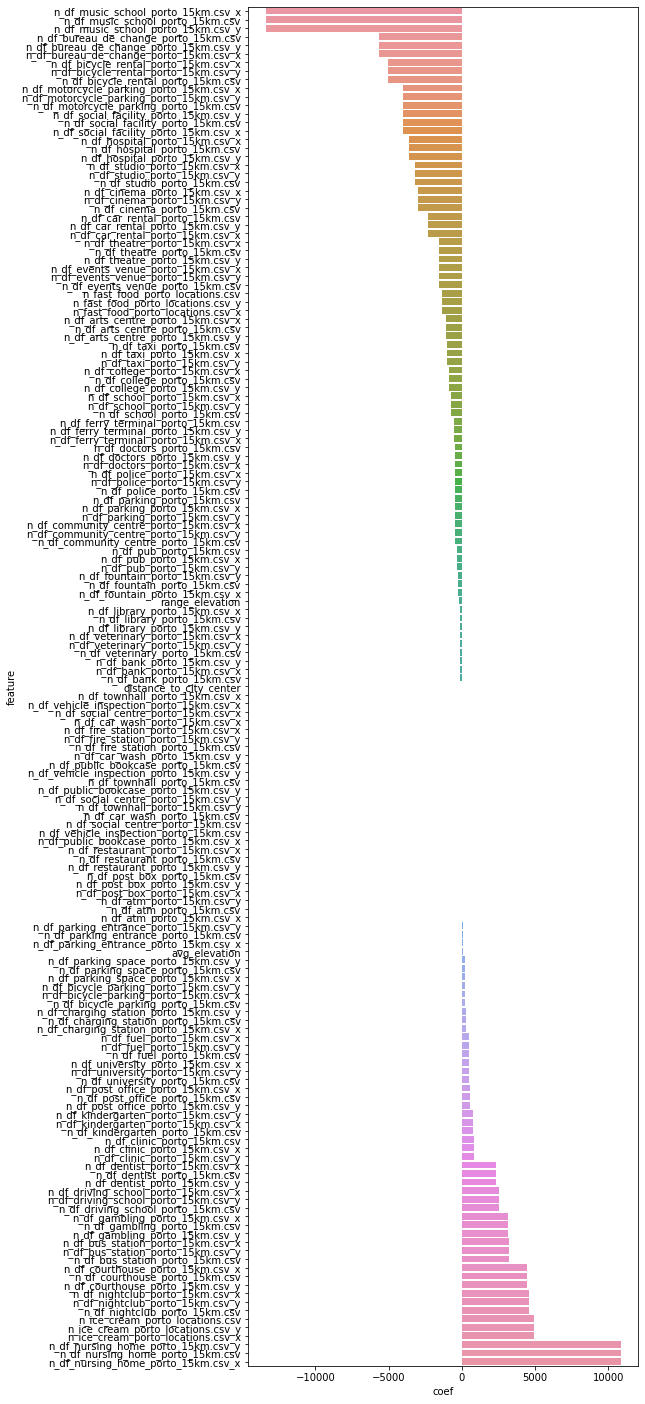

In [738]:
feature_scores = lin_reg_mod.coef_.tolist()
df_scores=pd.DataFrame()
df_scores["feature"]=x_headers
df_scores["coef"]=feature_scores
df = df_scores.sort_values(by = ['coef'])

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 25))
plot=sns.barplot(y="feature", x="coef", data=df)

## Interpretation 

###### "Feature category 1" 
We see that there are features with high importance in this category for example the number of nursing homes, ice cream shops, gambling, curthouses, driving schools and universities. One would have to verify whether this correlation is due to a causation. This would path the way for a recommendation for an improved service for senior citizens. One such recommendation could be to cooperate with the companys owning nursing homes to improve for example the access to buses by making bus stations more available for elderly people by removing physical hudles such as gaps between the busses and platforms.Furhtermore, one could create small bus lines that at few regular times, connect these nursing homes with amenities where senior citizens can satisfy their basic needs such as supermarkets and which offer especial care to their passengers like longer waiting times for people to get on and off the bus. 


##### "Feature category 2"
We see that the number of bus stations have a high positive importance. Again, if one were to identify that this is due to a causation one clearly can recommend to increase the number of buses to make the public transport service more senior citizens friendly .

# Future work

Our goal was to understand what drives senior poeple to move around Porto: what are the areas with the highest density of senior travellers? what amenities are in those areas? what are the geographical characteristics of those areas? As future steps, we would suggest applying this anylisis to senior travellers from different regions individually. This could further improve the understanding of their transportation needs and help design a more region specific public transportation plan. Additionally, if we could get access to data regarding the public travel of other age groups, we could look for they interact between each other, such that a better synergy can be achieved for the needs of all travellers. 

# Thank you!